## This Notebook calculates the number of genes mentioned in the GPT 4 analysis paragraph 

In [1]:
def get_LLM_gene_count(genes_fixed, LLM_analysis):
    system_genes_set = set(genes_fixed.split(" "))
    # Count the number of genes in the set that are mentioned in the LLM analysis
    overlaps = sum(1 for system_gene in system_genes_set if system_gene in LLM_analysis) 
    return overlaps

In [2]:
import pandas as pd
df = pd.read_csv('./data/GO_term_analysis/simrank_pval_LLM_processed_selected_1000_go_terms.tsv', sep='\t')

perc_gene_mentioned = []
counts = []
for ind, row in df.iterrows():
    genes = row['Genes']
    genecount = float(row['Gene_Count'])
    assert genecount == len(genes.split(" ")) # make sure the gene count is correct
    
    analysis = row['gpt_4_default Analysis']
    overlap_counts = get_LLM_gene_count(genes, analysis)
    counts.append(overlap_counts)
    perc_gene_mentioned.append(overlap_counts/genecount)

df['num_gene_mentioned'] = counts
df['perc_gene_mentioned'] = perc_gene_mentioned

df.to_csv('./data/GO_term_analysis/simrank_pval_LLM_processed_selected_1000_go_terms.tsv', sep='\t', index=False)

In [3]:
df['perc_gene_mentioned'].describe()

count    1000.000000
mean        0.916922
std         0.172690
min         0.166667
25%         0.946111
50%         1.000000
75%         1.000000
max         1.000000
Name: perc_gene_mentioned, dtype: float64

In [4]:
# find the number of times that covers at least 90% of the genes

print("Number of GO terms that cover at least 90% of the genes: {}".format(sum(1 for i in perc_gene_mentioned if i >= 0.9)))
print("Number of GO terms that cover at least 50% of the genes: {}".format(sum(1 for i in perc_gene_mentioned if i >= 0.5)))

Number of GO terms that cover at least 90% of the genes: 797
Number of GO terms that cover at least 50% of the genes: 942


In [5]:
#check the size of the GO terms for outliers
import numpy as np

# Calculate quartiles and IQR
q1 = np.percentile(df['perc_gene_mentioned'], 25)
q3 = np.percentile(df['perc_gene_mentioned'], 75)
iqr = q3 - q1

# Calculate the upper and lower bounds for outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Extract the outliers from the DataFrame
outliers = df[(df['perc_gene_mentioned'] < lower_bound) | (df['perc_gene_mentioned'] > upper_bound)]
print('lower bound: {}'.format(lower_bound))
print("Number of outliers: {}".format(len(outliers)))
# outliers size distribution
outliers['Gene_Count'].describe()

lower bound: 0.8652777777777778
Number of outliers: 186


count    186.000000
mean      55.854839
std       20.657710
min        6.000000
25%       40.000000
50%       53.000000
75%       72.000000
max      100.000000
Name: Gene_Count, dtype: float64

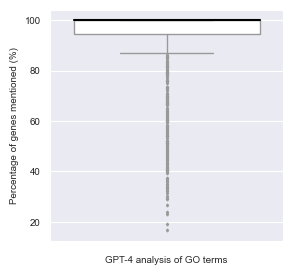

In [6]:
## plot a box plot 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
df = pd.read_csv('./data/GO_term_analysis/simrank_pval_LLM_processed_selected_1000_go_terms.tsv', sep='\t')
perc_gene_mentioned = df['perc_gene_mentioned'].tolist()
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7, 'font.family': 'sans-serif'})
fig,ax = plt.subplots(figsize=(3,3))

box_plot = sns.boxplot(y=[frac *100 for frac in perc_gene_mentioned], ax=ax, color='white', linewidth=1, fliersize=1.5)

# changing color and linewidth of the median line
median_line = box_plot.get_lines()[4] # get the median line
median_line.set_color('black') # change the color
median_line.set_linewidth(1.5) # change the linewidth

ax.set_ylabel("Percentage of genes mentioned (%)")
ax.set_xlabel("GPT-4 analysis of GO terms")

plt.savefig('./figures/LLM_GO_gene_mention_percentage.svg', dpi = 300,bbox_inches='tight')
plt.show()

In [7]:
## collect top 10 and bottom 10 
import pandas as pd 
df = pd.read_csv('./data/GO_term_analysis/simrank_pval_LLM_processed_selected_1000_go_terms.tsv', sep='\t')
# not include the 'System of unrelated proteins'
df.drop(df[df['gpt_4_default Name'] == 'System of unrelated proteins'].index, inplace = True)
df = df.sort_values(by=['true_GO_term_sim_percentile', 'LLM_name_GO_term_sim'], ascending=False)
top = df.head(5)
bottom = df.tail(5)
combine_df = pd.concat([top,bottom], ignore_index=True)
combine_df.to_csv('./data/GO_term_analysis/LLM_processed_GO_representative_top_bottom_5.tsv', sep='\t', index=False)
combine_df

,GO,Genes,Gene_Count,Term_Description,gpt_4_default Name,gpt_4_default Analysis,gpt_4_default Score,gpt_4_default Score Bin,LLM_name_GO_term_sim,sim_rank,...,top_3_hits,top_3_sim,pvals,adj_pvals,random_pvals,random_adj_pvals,JI,random JI,num_gene_mentioned,perc_gene_mentioned
0,GO:0009081,HIBCH BCAT1 HMGCLL1 ACADSB BCKDHA SLC25A44 SDS...,27,branched-chain amino acid metabolic process,Branched-Chain Amino Acid Metabolism and Catab...,"1. The proteins HIBCH, BCAT1, BCAT2, BCKDHA, B...",0.95,High Confidence,0.946014,1,...,branched-chain amino acid metabolic process|br...,0.9460139|0.87900156|0.83314335,6.426397022410732e-87|2.154030905169728e-64|6....,1.691157111160719e-85|5.523156167101867e-63|3....,1.0,1.0,1.0|0.7777777777777778|0.18518518518518517,0.0,26,0.962963
1,GO:0048240,EFCAB9 ADAM7 TCP11 CATSPER4 SPINK1 BSPH1 ROPN1...,33,sperm capacitation,Sperm Capacitation and Fertilization,1. The majority of the proteins listed are rel...,0.92,High Confidence,0.936600,1,...,sperm capacitation|regulation of sperm capacit...,0.9366003|0.7948351|0.7883392,2.1280089332582335e-103|1.9935150264533243e-14...,7.60003190449369e-102|8.8554274588964e-14|1.01...,1.0,1.0,1.0|0.15151515151515152|0.06060606060606061,0.0,20,0.606061
2,GO:0006768,BTD MCCC1 HLCS SLC5A6,4,biotin metabolic process,Biotin Metabolism and Catabolism,"1. BTD, or biotinidase, is an enzyme that recy...",0.89,High Confidence,0.933146,1,...,biotin metabolic process|biotin transport|coba...,0.93314576|0.76734674|0.7521958,2.85903800815798e-16|0.0007048043924525059|1.0,1.181420664528091e-15|0.0013149335680084065|1.0,1.0,1.0,1.0|0.16666666666666666|0.0,0.0,4,1.000000
3,GO:0090183,PAX8 WNT4 BASP1 GDNF SOX9 TACSTD2 GREM1 HNF1B ...,34,regulation of kidney development,Kidney Development and Function Regulation,"1. Several proteins in this system, including ...",0.92,High Confidence,0.912659,1,...,regulation of kidney development|kidney develo...,0.91265875|0.8040259|0.7702517,4.2585228799752766e-106|1.991676329704935e-60|...,1.6378934153751065e-104|4.064645570826398e-59|...,1.0,1.0,1.0|0.10793650793650794|0.16279069767441862,0.0,33,0.970588
4,GO:0001732,EIF3C EIF3E EIF3M EIF3D EIF5 EIF3K EIF3F EIF3B...,15,formation of cytoplasmic translation initiatio...,Eukaryotic Translation Initiation Complex Asse...,1. The eukaryotic initiation factors (eIFs) ar...,0.98,High Confidence,0.909025,1,...,formation of cytoplasmic translation initiatio...,0.9090252|0.77489007|0.7727462,4.504407445815161e-52|3.593179735087371e-33|6....,5.701781576981217e-51|3.0194787689809845e-32|1...,1.0,1.0,1.0|0.12096774193548387|0.39473684210526316,0.0,15,1.000000
5,GO:2000065,REST BMP5 BMP2 DKK3,4,negative regulation of cortisol biosynthetic p...,Regulation of Neurogenesis and Bone Morphogenesis,"1. REST, also known as RE1-Silencing Transcrip...",0.85,Medium Confidence,0.170712,11207,...,regulation of neurogenesis|regulation of bone ...,0.7791767|0.7555887|0.7188432,0.0029398113167312862|1.0|0.02375509025866538,0.004726384753587277|1.0|0.04152987807458983,1.0,1.0,0.005194805194805195|0.0|0.009523809523809525,0.0,4,1.000000
6,GO:0001542,SIRT1 MMP2 FOXO3 NOS3 NRIP1 PGR ADAMTS1 AFP LEP,9,ovulation from ovarian follicle,Regulation of Metabolic and Cardiovascular Pro...,"1. SIRT1, or sirtuin 1, is a NAD-dependent dea...",0.85,Medium Confidence,0.131500,11242,...,regulation of metabolic process|regulation of ...,0.72351325|0.7129016|0.6734365,0.07530245980152894|1.0|0.008954116541057816,0.10176008081287695|1.0|0.017055460078205364,1.0,1.0,0.0009358914365933552|0.0|0.04,0.0,9,1.000000
7,GO:1902966,RDX ROCK2 DTX3L EZR EGF MSN MGAT3 NF2 SORL1,9,positive regulation of protein localization to...,Actin Cytoskeleton Regulation and Signal Trans...,1. RDX (radixin) and EZR (ezrin) are members o...,0.85,Medium Confidence,0.149689,11325,...,actin cytoskeleton organization|regulation of ...,0.78401446|0.75558466|0.73912597,0.00031448591713256275|2.5111480956844267e-05|...,0.0005566122427125004|5.543373279656571e-05|4....,1.0,1.0,0.00